In [1]:
import torch 
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms

In [2]:
torch.cuda.is_available()

True

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomCrop(32, padding=4), 
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.2, 0.1)  # not strengthened
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

dataset = {
    'train': datasets.CIFAR100('/tmp', train=True, download=True, transform=data_transforms['train']),
    'test': datasets.CIFAR100('/tmp', train=False, download=True, transform=data_transforms['test'])
}

BATCH_SIZE = 128


dataloader = torch.utils.data.DataLoader(
            dataset['train'],
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=8,
            pin_memory = True)

test_dataloader = torch.utils.data.DataLoader(
            dataset['test'],
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=8,
            pin_memory = True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
import torch
import torch.nn as nn
#import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

def pair(x):
    return x if isinstance(x, tuple) else (x,x)


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super(PreNorm, self).__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)
    
class FeedForward(nn.Sequential):
    def __init__(self, dim, hidden_dim, dropout=0.1):
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.1):
        super(Attention, self).__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim), 
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda x: rearrange(x, 'b n (h d) -> b h n d', h=self.heads), qkv)  #b head sequence_len embed_size

        qk = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attention = self.softmax(qk)
        attention = self.dropout(attention)

        out = torch.matmul(attention, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim=1024, dropout=0.1):
        super(Transformer, self).__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x 

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim=1024, pool='cls', channels=3, dim_head=64, dropout=0.1, embed_dropout=0.1):
        super(ViT, self).__init__()
        image_h, image_w = pair(image_size)
        patch_h, patch_w = pair(patch_size)
        assert image_h % patch_h == 0 and image_w % patch_w == 0

        num_patches = (image_h // patch_h) * (image_w // patch_w)
        patch_dim = channels * patch_h * patch_w
        assert pool in {'cls', 'mean'}

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_h, p2=patch_w),
            nn.Linear(patch_dim, dim)
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim)) # 1 is cls_token 
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.embed_dropout = nn.Dropout(embed_dropout)
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)
        self.pool = pool 
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    
    def forward(self, x):
        x = self.to_patch_embedding(x)
        b, n, _ = x.shape
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n+1)]
        x = self.embed_dropout(x)
        x = self.transformer(x)
        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]
        out = self.mlp_head(x)
        return out 


def test():
    v = ViT(
        image_size = 256,
        patch_size = 32,
        num_classes = 100,
        dim = 1024,
        depth = 6,
        heads = 16,
        mlp_dim = 1024,
        dropout = 0.1,
        embed_dropout = 0.1
    )

    img = torch.randn(1, 3, 256, 256)

    preds = v(img)
    assert preds.shape == (1, 100)

In [6]:
def plot_train_val(train_loss, val_loss):
    e = len(train_loss)
    x_axis = np.arange(1, e + 1, 1)
    plt.figure()
    plt.plot(x_axis, train_loss, label="Training Loss")
    plt.plot(x_axis, val_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.legend(loc='best')
    plt.title("Loss Stats Plot")
    plt.show()

In [7]:
import matplotlib.pyplot as plt
def plot_stats(losses):
    e = len(losses)
    x_axis = np.arange(1, e + 1, 1)
    plt.figure()
    plt.plot(x_axis, losses, label="Training Loss")
    plt.xlabel("Epochs")
    plt.legend(loc='best')
    plt.title("Training Loss Stats Plot")
    plt.show()

In [8]:
NUM_CLASSES = 100
model = ViT(
        image_size = 32,
        patch_size = 4,
        num_classes = 100,
        dim = 512,
        depth = 6,
        heads = 16,
        mlp_dim = 1024,
        dropout = 0.1,
        embed_dropout = 0.1
    )
model = model.to(device)

In [8]:
import numpy as np
from torch.cuda.amp import GradScaler, autocast
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, lr_scheduler, Adam

EPOCHS = 30

opt = Adam(model.parameters(), lr= 3e-4, weight_decay=1e-4)
scheduler = lr_scheduler.LinearLR(opt, start_factor=0.9)

scaler = GradScaler()
loss_fn = CrossEntropyLoss(label_smoothing=0.1).cuda()

NameError: name 'model' is not defined

  0%|          | 0/391 [00:00<?, ?it/s]

[0.000276] 0


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0  Training loss: 4.002327161676743 Val loss: 3.6050790593593933


  0%|          | 0/391 [00:00<?, ?it/s]

[0.000282] 1


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1  Training loss: 3.5178001945280966 Val loss: 3.333853637115865


  0%|          | 0/391 [00:00<?, ?it/s]

[0.000288] 2


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2  Training loss: 3.3179748168077006 Val loss: 3.2282983260818674


  0%|          | 0/391 [00:00<?, ?it/s]

[0.000294] 3


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3  Training loss: 3.1678348227839948 Val loss: 3.070177232162862


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 4


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4  Training loss: 3.046260467880522 Val loss: 3.0063504538958585


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 5


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5  Training loss: 2.9443177804922507 Val loss: 2.8828453293329552


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 6


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6  Training loss: 2.848178871452351 Val loss: 2.8036652607253836


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 7


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7  Training loss: 2.7626157678911447 Val loss: 2.7362952202181274


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 8


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8  Training loss: 2.6774302675291097 Val loss: 2.710702247257474


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 9


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9  Training loss: 2.6054482496607942 Val loss: 2.630165640311905


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 10


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10  Training loss: 2.5314474154616255 Val loss: 2.604207941248447


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 11


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11  Training loss: 2.4618288001136097 Val loss: 2.554646096652067


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 12


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12  Training loss: 2.3986736380535625 Val loss: 2.511018064957631


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 13


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13  Training loss: 2.3397472904771184 Val loss: 2.483447642265996


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 14


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14  Training loss: 2.2792082430456606 Val loss: 2.445593622666371


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 15


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15  Training loss: 2.222343507325253 Val loss: 2.408207138882408


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 16


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16  Training loss: 2.165579605895235 Val loss: 2.3851055314269245


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 17


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17  Training loss: 2.1058377670814923 Val loss: 2.38365995582146


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 18


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18  Training loss: 2.0555686523847263 Val loss: 2.349797755857057


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 19


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19  Training loss: 2.005590414452126 Val loss: 2.3588301441337487


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 20


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 20  Training loss: 1.9585578164176258 Val loss: 2.3306781551505944


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 21


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 21  Training loss: 1.9052941360132163 Val loss: 2.319313671015486


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 22


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 22  Training loss: 1.8645556006590118 Val loss: 2.3332435918759695


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 23


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 23  Training loss: 1.81568667498391 Val loss: 2.2975715262980403


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 24


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 24  Training loss: 1.7740617856345213 Val loss: 2.291253270982187


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 25


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 25  Training loss: 1.7230881220849275 Val loss: 2.3127018620696247


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 26


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 26  Training loss: 1.6930204093303827 Val loss: 2.2916378190245807


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 27


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 27  Training loss: 1.6514891754940648 Val loss: 2.315408395815499


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 28


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 28  Training loss: 1.6150671417450966 Val loss: 2.3047168948982337


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 29


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 29  Training loss: 1.5759862588189752 Val loss: 2.318519513818282


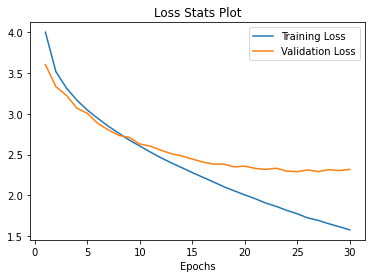

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy: 55.7%


In [10]:
from tqdm.notebook import tqdm

training_losses = []
val_losses = []

for ep in range(EPOCHS):
    
    epoch_loss = 0
    val_loss = 0
    model.train()
    for ims, labs in tqdm(dataloader):
        ims = ims.to(device)
        labs = labs.to(device)
        opt.zero_grad(set_to_none=True)
        with autocast():
            out = model(ims)
            loss = loss_fn(out, labs)
            epoch_loss += loss.item()
            
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
    scheduler.step()
    print(scheduler.get_last_lr(), ep)
    
    model.eval()
    with torch.no_grad():
        for ims, labs in tqdm(test_dataloader):
            ims = ims.to(device)
            labs = labs.to(device)
            with autocast():
                out = model(ims)
                loss = loss_fn(out, labs)
                val_loss += loss.item()
    

    epoch_loss = epoch_loss/ len(dataloader)
    val_loss = val_loss / len(test_dataloader)
    training_losses.append(epoch_loss)
    val_losses.append(val_loss)
    print( f'Epoch: {ep}  Training loss: {epoch_loss} Val loss: {val_loss}')

plot_train_val(training_losses, val_losses)

model.eval()
with torch.no_grad():
    total_correct, total_num = 0., 0.
    for ims, labs in tqdm(test_dataloader):
        ims = ims.to(device)
        labs = labs.to(device)
        with autocast():
            out = model(ims)   #(model(ims) + model(ch.fliplr(ims))) / 2. # Test-time augmentation
            total_correct += out.argmax(1).eq(labs).sum().cpu().item()
            total_num += ims.shape[0]

    print(f'Accuracy: {total_correct / total_num * 100:.1f}%')

In [15]:
scheduler = lr_scheduler.ReduceLROnPlateau(opt, factor=0.3, patience=5)

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 30  Training loss: 1.541618240458886 Val loss: 2.3350368028954613


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 31  Training loss: 1.506918087334889 Val loss: 2.3577125193197515


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 32  Training loss: 1.476325247598731 Val loss: 2.3520023702066157


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 33  Training loss: 1.444158797068974 Val loss: 2.34037705614597


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 34  Training loss: 1.4182426054459398 Val loss: 2.3617301258859755


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 35  Training loss: 1.3972068564666202 Val loss: 2.3614818506603


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 36  Training loss: 1.3666690557509127 Val loss: 2.397884293447567


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 37  Training loss: 1.1712816133523536 Val loss: 2.293371055699602


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 38  Training loss: 1.1109369499299226 Val loss: 2.2757814971706534


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 39  Training loss: 1.0915673367507623 Val loss: 2.305689319779601


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 40  Training loss: 1.0794403232881784 Val loss: 2.2990475364878207


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 41  Training loss: 1.0675174828685459 Val loss: 2.303960352004329


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 42  Training loss: 1.057749942440511 Val loss: 2.3120651546912856


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 43  Training loss: 1.0520601921983996 Val loss: 2.318963630289971


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 44  Training loss: 1.044768853565616 Val loss: 2.327219947983947


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 45  Training loss: 1.005095994990805 Val loss: 2.305339484275142


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 46  Training loss: 0.9916192409022689 Val loss: 2.300691426554813


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 47  Training loss: 0.9867246913178193 Val loss: 2.296078872077073


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 48  Training loss: 0.9829356005734495 Val loss: 2.293923734109613


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 49  Training loss: 0.9814185448314833 Val loss: 2.3031145892565763


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 50  Training loss: 0.9777725793211661 Val loss: 2.3023626049862633


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 51  Training loss: 0.9662794406761599 Val loss: 2.2997670113285884


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 52  Training loss: 0.965302405607365 Val loss: 2.301968615266341


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 53  Training loss: 0.9621344720920944 Val loss: 2.3077017415927936


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 54  Training loss: 0.9597592876695306 Val loss: 2.305037506019013


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 55  Training loss: 0.9603939496952555 Val loss: 2.303256846681426


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 56  Training loss: 0.9591183607535594 Val loss: 2.3059238210509094


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 57  Training loss: 0.9563895758155667 Val loss: 2.3049591402464276


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 58  Training loss: 0.9559392084550979 Val loss: 2.3041263818740845


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 59  Training loss: 0.9547730040977068 Val loss: 2.3050743296176575


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 60  Training loss: 0.9550391266413052 Val loss: 2.3049420737013033


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 61  Training loss: 0.9541052355790687 Val loss: 2.304713544966299


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 62  Training loss: 0.953117950645554 Val loss: 2.3033053965508183


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 63  Training loss: 0.9527184743710491 Val loss: 2.3039579421659058


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 64  Training loss: 0.95189368724823 Val loss: 2.304353484624549


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 65  Training loss: 0.9529236283753534 Val loss: 2.303694725036621


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 66  Training loss: 0.9513013195198821 Val loss: 2.3036067878143696


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 67  Training loss: 0.9523071645165954 Val loss: 2.302812859981875


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 68  Training loss: 0.9535780966739216 Val loss: 2.302891290640529


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 69  Training loss: 0.9513220665095102 Val loss: 2.3031640113154546


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 70  Training loss: 0.9505618830471088 Val loss: 2.303536792344685


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 71  Training loss: 0.9524484606045286 Val loss: 2.30300234842904


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 72  Training loss: 0.951679183394098 Val loss: 2.3036312045930307


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 73  Training loss: 0.9519978999481786 Val loss: 2.304064488109154


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 74  Training loss: 0.9512606516213673 Val loss: 2.304074898550782


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 75  Training loss: 0.9508360217294425 Val loss: 2.3040684371054927


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 76  Training loss: 0.9506682561486578 Val loss: 2.304129926464226


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 77  Training loss: 0.9515893991341067 Val loss: 2.3040502901318707


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 78  Training loss: 0.9515217903934782 Val loss: 2.304038674016542


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 79  Training loss: 0.9521388972506803 Val loss: 2.304091773455656


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 80  Training loss: 0.9517206485619021 Val loss: 2.30411547497858


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 81  Training loss: 0.9499591537143873 Val loss: 2.3041274200511883


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 82  Training loss: 0.950336225959651 Val loss: 2.304135479504549


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 83  Training loss: 0.9512437290852637 Val loss: 2.3041193334362173


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 84  Training loss: 0.9520046787188791 Val loss: 2.304111927370482


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 85  Training loss: 0.9508722555606871 Val loss: 2.30417163915272


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 86  Training loss: 0.9510973382483968 Val loss: 2.304112823703621


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 87  Training loss: 0.9511261646400022 Val loss: 2.3041270277168175


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 88  Training loss: 0.9508522415100156 Val loss: 2.3041354734686355


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 89  Training loss: 0.9510809803557823 Val loss: 2.304127539260478


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 90  Training loss: 0.9513156490252755 Val loss: 2.3041470956198777


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 91  Training loss: 0.9503678868493766 Val loss: 2.3041458009164546


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 92  Training loss: 0.9510821515641859 Val loss: 2.304116677634324


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 93  Training loss: 0.9518029733996867 Val loss: 2.3041333382642724


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 94  Training loss: 0.9516341978936549 Val loss: 2.3041294616988943


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 95  Training loss: 0.9514732818164484 Val loss: 2.3041421914402442


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 96  Training loss: 0.9517934262904975 Val loss: 2.304141385645806


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 97  Training loss: 0.9502851463034939 Val loss: 2.3041413403764555


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 98  Training loss: 0.9491814538036161 Val loss: 2.304127566422088


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 99  Training loss: 0.9525248745213384 Val loss: 2.304139912882938


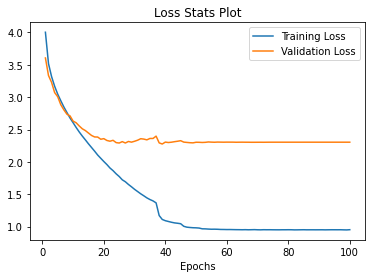

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy: 59.1%


In [17]:
for ep in range(60, 120, 1):
    
    epoch_loss = 0
    val_loss = 0
    model.train()
    for ims, labs in tqdm(dataloader):
        ims = ims.to(device)
        labs = labs.to(device)
        opt.zero_grad(set_to_none=True)
        with autocast():
            out = model(ims)
            loss = loss_fn(out, labs)
            epoch_loss += loss.item()
            
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
   
    model.eval()
    with torch.no_grad():
        for ims, labs in tqdm(test_dataloader):
            ims = ims.to(device)
            labs = labs.to(device)
            with autocast():
                out = model(ims)
                loss = loss_fn(out, labs)
                val_loss += loss.item()
    
    val_loss = val_loss / len(test_dataloader)
    scheduler.step(val_loss)
    
    epoch_loss = epoch_loss/ len(dataloader)
    
    training_losses.append(epoch_loss)
    val_losses.append(val_loss)
    print( f'Epoch: {ep}  Training loss: {epoch_loss} Val loss: {val_loss}')

plot_train_val(training_losses, val_losses)

model.eval()
with torch.no_grad():
    total_correct, total_num = 0., 0.
    for ims, labs in tqdm(test_dataloader):
        ims = ims.to(device)
        labs = labs.to(device)
        with autocast():
            out = model(ims)   
            total_correct += out.argmax(1).eq(labs).sum().cpu().item()
            total_num += ims.shape[0]

    print(f'Accuracy: {total_correct / total_num * 100:.1f}%')

In [12]:
model = ViT(
        image_size = 32,
        patch_size = 4,
        num_classes = 100,
        dim = 512,
        depth = 6,
        heads = 10,
        mlp_dim = 1024,
        dropout = 0.1,
        embed_dropout = 0.1
    )
model = model.to(device)

  0%|          | 0/391 [00:00<?, ?it/s]

[0.000276] 0


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0  Training loss: 4.274699345269166 Val loss: 3.8307063277763658


  0%|          | 0/391 [00:00<?, ?it/s]

[0.000282] 1


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1  Training loss: 3.906819250882434 Val loss: 3.5421384738970407


  0%|          | 0/391 [00:00<?, ?it/s]

[0.000288] 2


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2  Training loss: 3.7269669109598147 Val loss: 3.3845601685439486


  0%|          | 0/391 [00:00<?, ?it/s]

[0.000294] 3


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3  Training loss: 3.6023771256741965 Val loss: 3.2628489627113826


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 4


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4  Training loss: 3.4916430763576343 Val loss: 3.172419439388227


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 5


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5  Training loss: 3.40023760295585 Val loss: 3.103748934178413


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 6


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6  Training loss: 3.306691278886917 Val loss: 3.0098341688325134


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 7


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7  Training loss: 3.205286664426174 Val loss: 2.9056497193589994


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 8


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8  Training loss: 3.123915394248865 Val loss: 2.860154251509075


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 9


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9  Training loss: 3.040130573160508 Val loss: 2.7712277189085754


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 10


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10  Training loss: 2.9691271147764553 Val loss: 2.7082237080682683


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 11


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11  Training loss: 2.893296189320362 Val loss: 2.675712669952006


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 12


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12  Training loss: 2.830124561743968 Val loss: 2.6252273547498484


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 13


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13  Training loss: 2.7589469059653906 Val loss: 2.5512066973915584


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 14


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14  Training loss: 2.7054630868575154 Val loss: 2.5095721890654743


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 15


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15  Training loss: 2.647887651267869 Val loss: 2.4747478297994108


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 16


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16  Training loss: 2.5910422247084206 Val loss: 2.417410446118705


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 17


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17  Training loss: 2.54259861155849 Val loss: 2.409919654266744


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 18


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18  Training loss: 2.4993616821211013 Val loss: 2.3646412559702426


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 19


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19  Training loss: 2.4649856822265077 Val loss: 2.3520822917358783


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 20


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 20  Training loss: 2.426661029191273 Val loss: 2.315326099154315


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 21


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 21  Training loss: 2.3798513534428825 Val loss: 2.2780423647240746


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 22


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 22  Training loss: 2.3587513043142647 Val loss: 2.2520461474792866


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 23


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 23  Training loss: 2.319438513587503 Val loss: 2.2886782265916654


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 24


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 24  Training loss: 2.2986836500484924 Val loss: 2.270940735370298


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 25


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 25  Training loss: 2.261401639874939 Val loss: 2.2141844803773902


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 26


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 26  Training loss: 2.226572350467867 Val loss: 2.2260926584654217


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 27


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 27  Training loss: 2.211754106804538 Val loss: 2.200649883173689


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 28


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 28  Training loss: 2.175138058869735 Val loss: 2.2196471962747695


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 29


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 29  Training loss: 2.159090782675292 Val loss: 2.1489385577696787


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 30


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 30  Training loss: 2.134598410038082 Val loss: 2.1493973535827444


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 31


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 31  Training loss: 2.107929130649323 Val loss: 2.152166772492324


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 32


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 32  Training loss: 2.0871921863092484 Val loss: 2.1594491291649733


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 33


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 33  Training loss: 2.0605596746020303 Val loss: 2.147894122932531


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 34


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 34  Training loss: 2.037386413730319 Val loss: 2.132426823241801


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 35


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 35  Training loss: 2.019902917430224 Val loss: 2.14809019656121


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 36


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 36  Training loss: 1.9985122323950844 Val loss: 2.126922811133952


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 37


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 37  Training loss: 1.9778267889071608 Val loss: 2.132283965243569


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 38


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 38  Training loss: 1.9558308478206625 Val loss: 2.135298485997357


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 39


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 39  Training loss: 1.935081434066948 Val loss: 2.1096174234076392


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 40


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 40  Training loss: 1.911500804564532 Val loss: 2.1310886944396588


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 41


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 41  Training loss: 1.8979282778547244 Val loss: 2.092313027080101


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 42


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 42  Training loss: 1.8693611908446797 Val loss: 2.121061249624325


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 43


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 43  Training loss: 1.8580338793337499 Val loss: 2.133142081997063


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 44


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 44  Training loss: 1.8466690107989494 Val loss: 2.1086637128757526


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 45


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 45  Training loss: 1.8208386867552462 Val loss: 2.1230847458296185


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 46


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 46  Training loss: 1.80664218417214 Val loss: 2.117723896533628


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 47


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 47  Training loss: 1.7911876522366652 Val loss: 2.1173325052744225


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 48


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 48  Training loss: 1.7780298945848898 Val loss: 2.1010468021223816


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 49


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 49  Training loss: 1.7548460801848975 Val loss: 2.1136384447918664


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 50


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 50  Training loss: 1.7521403933425084 Val loss: 2.1101235679433317


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 51


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 51  Training loss: 1.7182123502502051 Val loss: 2.1036743755582012


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 52


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 52  Training loss: 1.7139482894516966 Val loss: 2.11061171338528


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 53


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 53  Training loss: 1.6997655428888854 Val loss: 2.128449811211115


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 54


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 54  Training loss: 1.6851698833963145 Val loss: 2.095301852950567


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 55


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 55  Training loss: 1.6730929826531569 Val loss: 2.0955837527407875


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 56


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 56  Training loss: 1.6564383832999812 Val loss: 2.1095462569707557


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 57


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 57  Training loss: 1.650613615275039 Val loss: 2.1069215792643874


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 58


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 58  Training loss: 1.628807009943306 Val loss: 2.1289114559753033


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 59


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 59  Training loss: 1.6254377749265003 Val loss: 2.1152699959429007


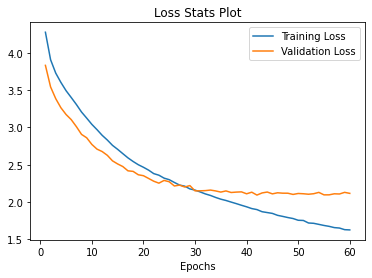

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy: 61.6%


In [11]:
import numpy as np
from torch.cuda.amp import GradScaler, autocast
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, lr_scheduler, Adam
from tqdm.notebook import tqdm
EPOCHS = 60

opt = Adam(model.parameters(), lr= 3e-4, weight_decay=1e-4)
scheduler = lr_scheduler.LinearLR(opt, start_factor=0.9)

scaler = GradScaler()
loss_fn = CrossEntropyLoss(label_smoothing=0.1).cuda()
training_losses = []
val_losses = []

for ep in range(EPOCHS):
    
    epoch_loss = 0
    val_loss = 0
    model.train()
    for ims, labs in tqdm(dataloader):
        ims = ims.to(device)
        labs = labs.to(device)
        opt.zero_grad(set_to_none=True)
        with autocast():
            out = model(ims)
            loss = loss_fn(out, labs)
            epoch_loss += loss.item()
            
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
    scheduler.step()
    print(scheduler.get_last_lr(), ep)
    
    model.eval()
    with torch.no_grad():
        for ims, labs in tqdm(test_dataloader):
            ims = ims.to(device)
            labs = labs.to(device)
            with autocast():
                out = model(ims)
                loss = loss_fn(out, labs)
                val_loss += loss.item()
    

    epoch_loss = epoch_loss/ len(dataloader)
    val_loss = val_loss / len(test_dataloader)
    training_losses.append(epoch_loss)
    val_losses.append(val_loss)
    print( f'Epoch: {ep}  Training loss: {epoch_loss} Val loss: {val_loss}')

plot_train_val(training_losses, val_losses)

model.eval()
with torch.no_grad():
    total_correct, total_num = 0., 0.
    for ims, labs in tqdm(test_dataloader):
        ims = ims.to(device)
        labs = labs.to(device)
        with autocast():
            out = model(ims)   #(model(ims) + model(ch.fliplr(ims))) / 2. # Test-time augmentation
            total_correct += out.argmax(1).eq(labs).sum().cpu().item()
            total_num += ims.shape[0]

    print(f'Accuracy: {total_correct / total_num * 100:.1f}%')

  0%|          | 0/391 [00:00<?, ?it/s]

[0.000276] 0


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0  Training loss: 4.267650983522615 Val loss: 3.8137965896461585


  0%|          | 0/391 [00:00<?, ?it/s]

[0.000282] 1


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1  Training loss: 3.906226322169194 Val loss: 3.549333225322675


  0%|          | 0/391 [00:00<?, ?it/s]

[0.000288] 2


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2  Training loss: 3.728833278426734 Val loss: 3.3832904296585276


  0%|          | 0/391 [00:00<?, ?it/s]

[0.000294] 3


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3  Training loss: 3.604773052513142 Val loss: 3.2813976112800307


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 4


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4  Training loss: 3.500587632893906 Val loss: 3.197641511506672


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 5


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5  Training loss: 3.393686157968038 Val loss: 3.091876696936692


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 6


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6  Training loss: 3.2985044873279072 Val loss: 3.0331438885459416


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 7


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7  Training loss: 3.21262643404324 Val loss: 2.927496040923686


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 8


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8  Training loss: 3.1086152545021624 Val loss: 2.823952662793896


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 9


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9  Training loss: 3.015740452520073 Val loss: 2.759095288530181


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 10


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10  Training loss: 2.944918412381731 Val loss: 2.714632022229931


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 11


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11  Training loss: 2.8723663356907836 Val loss: 2.629102534885648


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 12


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12  Training loss: 2.8129512714912823 Val loss: 2.5859413056433955


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 13


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13  Training loss: 2.7436222127636376 Val loss: 2.5578590767293035


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 14


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14  Training loss: 2.6714204406494373 Val loss: 2.4727051469344126


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 15


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15  Training loss: 2.627525255808135 Val loss: 2.441702338713634


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 16


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16  Training loss: 2.574569843614193 Val loss: 2.4315766020666194


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 17


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17  Training loss: 2.5290193380907064 Val loss: 2.3997344759446158


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 18


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18  Training loss: 2.49042484461499 Val loss: 2.3973503988000413


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 19


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19  Training loss: 2.4518155917487183 Val loss: 2.337469206580633


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 20


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 20  Training loss: 2.413790069272756 Val loss: 2.3004426518573036


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 21


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 21  Training loss: 2.375707089748529 Val loss: 2.2609731260734267


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 22


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 22  Training loss: 2.34039543473812 Val loss: 2.261748947674715


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 23


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 23  Training loss: 2.309718934471345 Val loss: 2.2722621220576613


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 24


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 24  Training loss: 2.2811103547015765 Val loss: 2.228995024403439


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 25


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 25  Training loss: 2.2520341257305097 Val loss: 2.2072011443633066


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 26


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 26  Training loss: 2.2194044571703353 Val loss: 2.2109208786034884


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 27


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 27  Training loss: 2.1903603671456846 Val loss: 2.1785987253430523


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 28


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 28  Training loss: 2.1662569558224103 Val loss: 2.158788860598697


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 29


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 29  Training loss: 2.139424422817767 Val loss: 2.17032971110525


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 30


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 30  Training loss: 2.1130200597026465 Val loss: 2.1771285473545894


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 31


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 31  Training loss: 2.0927731753005396 Val loss: 2.144610595099534


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 32


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 32  Training loss: 2.064792863243376 Val loss: 2.1311419493035424


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 33


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 33  Training loss: 2.0483293313809368 Val loss: 2.158354765252222


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 34


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 34  Training loss: 2.0210159449930996 Val loss: 2.133985594858097


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 35


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 35  Training loss: 1.9984232769597827 Val loss: 2.1330234415923495


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 36


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 36  Training loss: 1.9755687488009557 Val loss: 2.0983530132076407


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 37


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 37  Training loss: 1.9520349563540096 Val loss: 2.1181236852573444


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 38


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 38  Training loss: 1.9320372498553733 Val loss: 2.1062890351573125


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 39


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 39  Training loss: 1.9120303782660637 Val loss: 2.128567095044293


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 40


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 40  Training loss: 1.897715665190421 Val loss: 2.1099014236957214


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 41


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 41  Training loss: 1.883593854087088 Val loss: 2.0903291687180725


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 42


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 42  Training loss: 1.8561351939540385 Val loss: 2.101251989980287


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 43


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 43  Training loss: 1.8480358474394853 Val loss: 2.0944789617876465


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 44


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 44  Training loss: 1.8296190262450587 Val loss: 2.0862860106214693


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 45


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 45  Training loss: 1.8109479554169012 Val loss: 2.1065874084641663


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 46


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 46  Training loss: 1.7882692286425539 Val loss: 2.1228278633914415


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 47


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 47  Training loss: 1.7828716594544822 Val loss: 2.1145187857784804


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 48


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 48  Training loss: 1.7622594705323125 Val loss: 2.093921158887163


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 49


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 49  Training loss: 1.7361583667033165 Val loss: 2.0999372744862037


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 50


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 50  Training loss: 1.730040388034128 Val loss: 2.0911292214936847


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 51


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 51  Training loss: 1.708860990336484 Val loss: 2.0750049488453923


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 52


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 52  Training loss: 1.7002623340357905 Val loss: 2.127788782119751


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 53


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 53  Training loss: 1.6802642915559851 Val loss: 2.1006170556515076


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 54


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 54  Training loss: 1.6675270204348942 Val loss: 2.116012861457052


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 55


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 55  Training loss: 1.6490732461900053 Val loss: 2.0834564528887785


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 56


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 56  Training loss: 1.634311311994977 Val loss: 2.1212111454975755


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 57


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 57  Training loss: 1.6230099707308328 Val loss: 2.09192921692812


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 58


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 58  Training loss: 1.617796677457707 Val loss: 2.0730100598516343


  0%|          | 0/391 [00:00<?, ?it/s]

[0.0003] 59


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 59  Training loss: 1.6086265104810904 Val loss: 2.0926688019233413


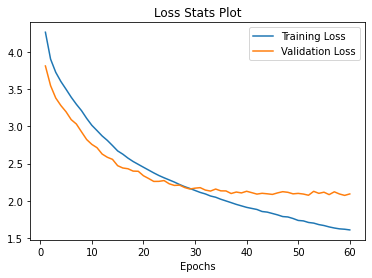

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy: 62.2%


In [13]:
import numpy as np
from torch.cuda.amp import GradScaler, autocast
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, lr_scheduler, Adam
from tqdm.notebook import tqdm
EPOCHS = 60

opt = Adam(model.parameters(), lr= 3e-4, weight_decay=1e-4)
scheduler = lr_scheduler.LinearLR(opt, start_factor=0.9)

#scaler = GradScaler()
loss_fn = CrossEntropyLoss(label_smoothing=0.1).cuda()
training_losses = []
val_losses = []

for ep in range(EPOCHS):
    
    epoch_loss = 0
    val_loss = 0
    model.train()
    for ims, labs in tqdm(dataloader):
        ims = ims.to(device)
        labs = labs.to(device)
        opt.zero_grad()
        #with torch.set_grad_enabled(True):
        out = model(ims)
        loss = loss_fn(out, labs)
        epoch_loss += loss.item()
            
        loss.backward()
        opt.step()
    scheduler.step()
    print(scheduler.get_last_lr(), ep)
    
    model.eval()
    with torch.no_grad():
        for ims, labs in tqdm(test_dataloader):
            ims = ims.to(device)
            labs = labs.to(device)
            out = model(ims)
            loss = loss_fn(out, labs)
            val_loss += loss.item()
    

    epoch_loss = epoch_loss/ len(dataloader)
    val_loss = val_loss / len(test_dataloader)
    training_losses.append(epoch_loss)
    val_losses.append(val_loss)
    print( f'Epoch: {ep}  Training loss: {epoch_loss} Val loss: {val_loss}')

plot_train_val(training_losses, val_losses)

model.eval()
with torch.no_grad():
    total_correct, total_num = 0., 0.
    for ims, labs in tqdm(test_dataloader):
        ims = ims.to(device)
        labs = labs.to(device)
        out = model(ims)   #(model(ims) + model(ch.fliplr(ims))) / 2. # Test-time augmentation
        total_correct += out.argmax(1).eq(labs).sum().cpu().item()
        total_num += ims.shape[0]

    print(f'Accuracy: {total_correct / total_num * 100:.1f}%')